In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [3]:
cd English\ -\ Marathi\ NMT

/content/gdrive/My Drive/English - Marathi NMT


In [0]:
!wget http://www.manythings.org/anki/mar-eng.zip

--2019-10-18 11:07:55--  http://www.manythings.org/anki/mar-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1174128 (1.1M) [application/zip]
Saving to: ‘mar-eng.zip’

mar-eng.zip         100%[===================>]   1.12M  1.00MB/s    in 1.1s    

2019-10-18 11:07:57 (1.00 MB/s) - ‘mar-eng.zip’ saved [1174128/1174128]



In [0]:
!unzip mar-eng.zip

Archive:  mar-eng.zip
  inflating: mar.txt                 
  inflating: _about.txt              


In [4]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [5]:
lines= pd.read_table('mar.txt', names=[0,'eng','mar'],index_col=None)
print(lines.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


(36503, 3)


In [6]:
lines["Eng"] = lines[0]
lines["Mar"] = lines["eng"]
lines = lines[["Eng","Mar"]]
lines.head()

,Eng,Mar
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


In [7]:
print(lines.shape)

(36503, 2)


### Data Cleaning

In [0]:
def clean_data(data):
  """
  This function cleans text by removing quotes, punctuations, extra spaces, numbers and lowercasing it
  """
  
  # lowercase
  data["Eng"] = data["Eng"].apply(lambda x:x.lower())
  data["Mar"] = data["Mar"].apply(lambda x:x.lower())

  # remove quotes
  data["Eng"] = data["Eng"].apply(lambda x: re.sub("'", '', x))
  data["Mar"] = data["Mar"].apply(lambda x: re.sub("'", '', x))

  # remove all punctuations
  punctuations = set(string.punctuation)
  data["Eng"] = data["Eng"].apply(lambda x: ''.join(val for val in x if val not in punctuations))
  data["Mar"] = data["Mar"].apply(lambda x: ''.join(val for val in x if val not in punctuations))

  # remove extra spaces
  data["Eng"] = data["Eng"].apply(lambda x: x.strip())
  data["Mar"] = data["Mar"].apply(lambda x: x.strip())
  
  # exclude numbers
  data["Eng"] = data["Eng"].apply(lambda x: re.sub("[0123456789]","",x))
  data["Mar"] = data["Mar"].apply(lambda x: re.sub("[२३०८१५७९४६]","",x))

  # Add start and end tokens to target sequences
  data["Mar"] = data["Mar"].apply(lambda x : 'START_ '+ x + ' _END')

  return data

In [9]:
lines = clean_data(lines)
lines.sample(5)

,Eng,Mar
18783,tom isnt alone in this,START_ टॉम यात एकटा नाहीये _END
540,i see them,START_ मी त्यांना बघते _END
1178,where is he,START_ कुठे आहेत ते _END
18899,we bought a round table,START_ आम्ही एक गोलाकार टेबल विकत घेतलं _END
29371,i dont know anything about this,START_ मला याबद्दल काहीही माहीत नाही _END


### Create vocabulary for both English and Marathi words

In [0]:
def create_vocab(data):
  """
  creates a vocab for english and marathi words
  """

  # Vocabulary of English words
  all_eng_words=set()
  for sentence_eng in data["Eng"]:
      for word in sentence_eng.split():
          if word not in all_eng_words:
              all_eng_words.add(word)

  # Vocabulary of Marathi words
  all_marathi_words=set()
  for sentence_mar in data["Mar"]:
      for word in sentence_mar.split():
          if word not in all_marathi_words:
              all_marathi_words.add(word)

  return all_eng_words, all_marathi_words

In [11]:
vocab_eng, vocab_mar = create_vocab(lines)
print(f"Size of vocab_eng = {len(vocab_eng)}")
print(f"Size of vocab_mar = {len(vocab_mar)}")

Size of vocab_eng = 5487
Size of vocab_mar = 13061


### Max sequence lengths

In [12]:
lengths_eng = [len(line.split(' ')) for line in lines["Eng"]]
max_len_eng = np.max(lengths_eng)
max_len_eng

35

In [13]:
lengths_mar = [len(line.split(' ')) for line in lines["Mar"]]
max_len_mar = np.max(lengths_mar)
max_len_mar

37

In [14]:
input_words = sorted(list(vocab_eng))
target_words = sorted(list(vocab_mar))
num_encoder_tokens = len(vocab_eng)
num_decoder_tokens = len(vocab_mar)
print(num_encoder_tokens, num_decoder_tokens)

num_decoder_tokens += 1 # For zero padding
print(num_decoder_tokens)

5487 13061
13062


In [0]:

input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

reverse_input_word_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict((i, word) for word, i in target_token_index.items())

In [0]:
lines = shuffle(lines)

In [0]:
# Train - Test Split
X, y = lines["Eng"], lines["Mar"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [0]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''

    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_len_eng),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_len_mar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_len_mar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder decoder architecture

In [21]:
latent_dim = 50

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     274350      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     653100      input_2[0][0]              

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100
256/256 [==============================] - 119s 464ms/step - loss: 6.4817 - acc: 0.1781 - val_loss: 5.8395 - val_acc: 0.1934
Epoch 2/100
256/256 [==============================] - 115s 448ms/step - loss: 5.6149 - acc: 0.2040 - val_loss: 5.5301 - val_acc: 0.2115
Epoch 3/100
256/256 [==============================] - 115s 448ms/step - loss: 5.2992 - acc: 0.2327 - val_loss: 5.2725 - val_acc: 0.2503
Epoch 4/100
256/256 [==============================] - 115s 447ms/step - loss: 5.0796 - acc: 0.2587 - val_loss: 5.1090 - val_acc: 0.2680
Epoch 5/100
256/256 [==============================] - 114s 446ms/step - loss: 4.8995 - acc: 0.2743 - val_loss: 4.9717 - val_acc: 0.2805
Epoch 6/100
256/256 [==============================] - 114s 446ms/step - loss: 4.7365 - acc: 0.2911 - val_loss: 4.8461 - val_acc: 0.2988
Epoch 7/100
256/256 [==============================] - 114s 446ms/step - loss: 4.5777 - acc: 0.3104 - val_loss: 4.7125 - val_acc: 0.3140
Epoch 8/100
256/256 [====================

In [0]:
# save weights
model.save_weights('nmt_eng_mar_weights.h5')

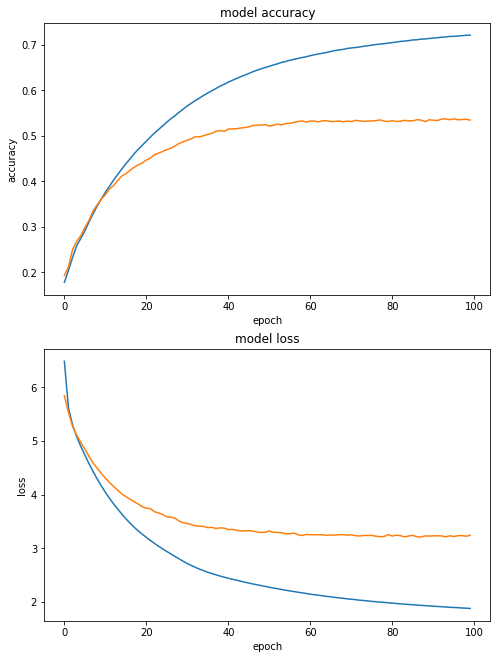

In [0]:
# plot the results
plt.figure(1, figsize=(8, 11))

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### load model and make predictions

In [25]:
model.load_weights('nmt_eng_mar_weights.h5')

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [34]:
for k in range(1,20):
  (input_seq, actual_output), _ = next(train_gen)
  decoded_sentence = decode_sequence(input_seq)
  print('Input English sentence:', X_train[k:k+1].values[0])
  print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
  print('Predicted Marathi Translation:', decoded_sentence[:-4])
  print("-"*50)

Input English sentence: dont open those windows
Actual Marathi Translation:  त्या खिडक्या उघडू नये 
Predicted Marathi Translation:  ते जबाबदार आहे 
--------------------------------------------------
Input English sentence: lets go see tom now
Actual Marathi Translation:  चल टॉमला भेटू या 
Predicted Marathi Translation:  तुला बॉस्टनमध्ये नका चालू राहिला 
--------------------------------------------------
Input English sentence: they named the baby momotarou
Actual Marathi Translation:  त्यांनी बाळाचं नाव मोमोतारोउ असं ठेवलं 
Predicted Marathi Translation:  इथे पुस्तक आहे 
--------------------------------------------------
Input English sentence: this isnt what i ordered
Actual Marathi Translation:  मी जे मागवलं होतं ते हे नाहीये 
Predicted Marathi Translation:  तिथे गरम आहे का 
--------------------------------------------------
Input English sentence: she is able to skate
Actual Marathi Translation:  ती स्केट करू शकते 
Predicted Marathi Translation:  मेरी वर्गात मुलगी नाहीये 
----------